# First approach to VAR estimation

## Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib
from random import random

## Importing data

In [2]:
# Importing data

mdata = sm.datasets.macrodata.load_pandas().data
mdata.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [3]:
# Basic data manipulation

dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]

# Pandas object to a time-series model expects that the index is dates

mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()
data.head()

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694


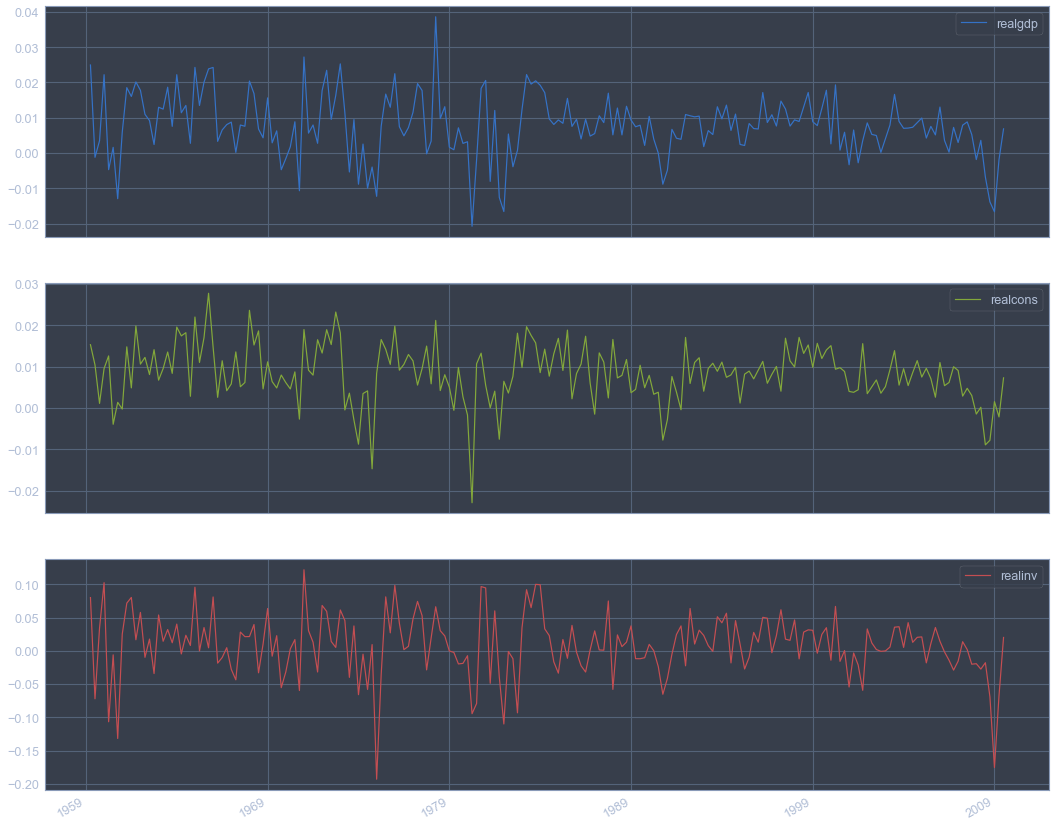

In [4]:
# Plot the data 

data.plot(subplots=True,figsize=(18, 16));

In [5]:
# Checking stationarity

coint_johansen(data,-1,1).eig

array([0.40101333, 0.24649629, 0.05677659])

## VAR

In [6]:
# VAR

model = VAR(data)
results = model.fit(2)
results.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Dec, 2018
Time:                     20:43:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

## Plots

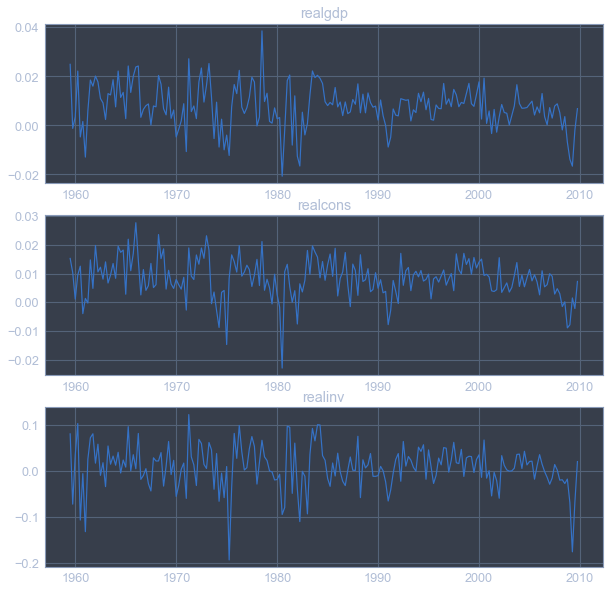

In [7]:
# Results

results.plot();

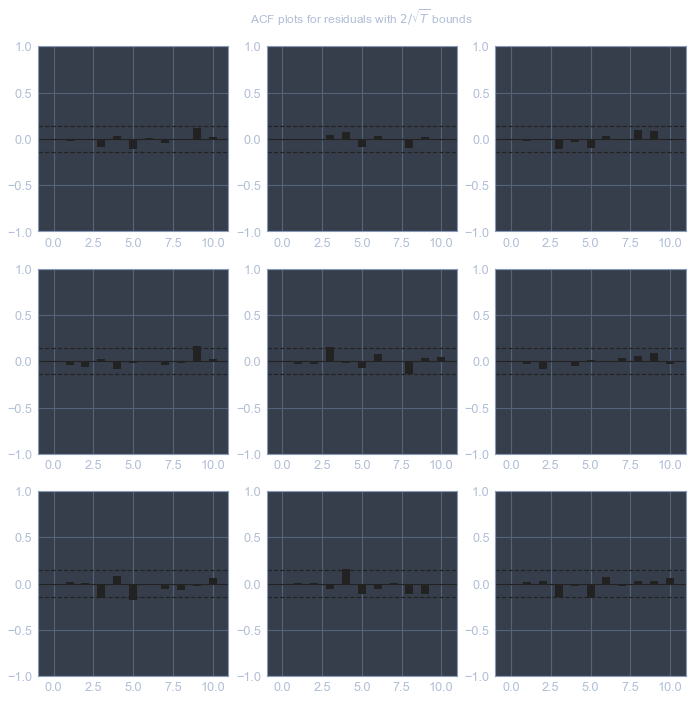

In [8]:
# Autocorrelation

results.plot_acorr();

## Lag order selection

In [9]:
# Adding maximum lag

model.select_order(5)

# Estimate model with maximum lag according to the AIC criterion

results = model.fit(maxlags=5, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Dec, 2018
Time:                     20:43:06
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.7388
Nobs:                     201.000    HQIC:                  -27.8562
Log likelihood:           1963.94    FPE:                7.37174e-13
AIC:                     -27.9360    Det(Omega_mle):     6.94859e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.003580         0.000911            3.928           0.000
L1.realgdp         -0.338056         0.172084           -1.964           0.049
L1.realcons         0.746283         0.130411            5.723    

## Forecasting

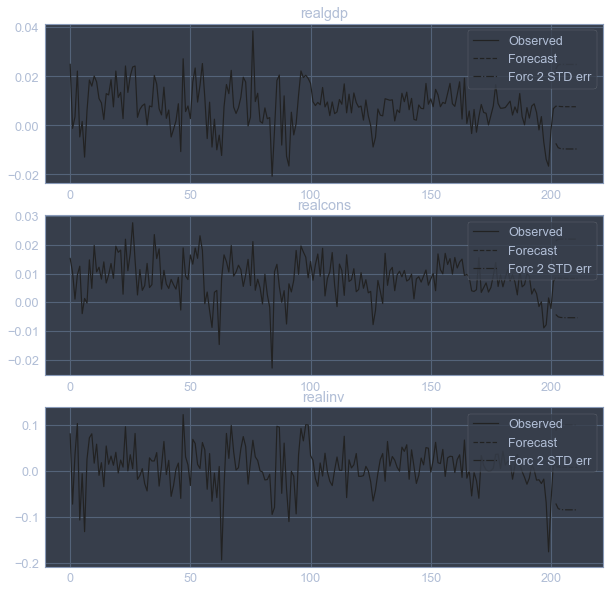

In [10]:
lag_order = results.k_ar

# Specify the initial value of forecast

results.forecast(data.values[-lag_order:], 5);

# Plot forecasts with confidence intervals

results.plot_forecast(10);

## Impulse Response Analysis

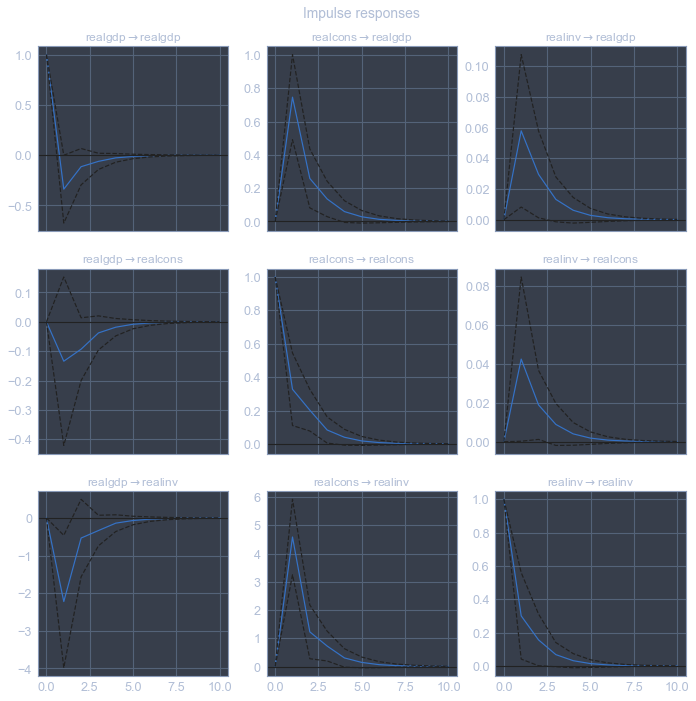

In [11]:
# IRF

irf = results.irf(10)
irf.plot(orth=False);

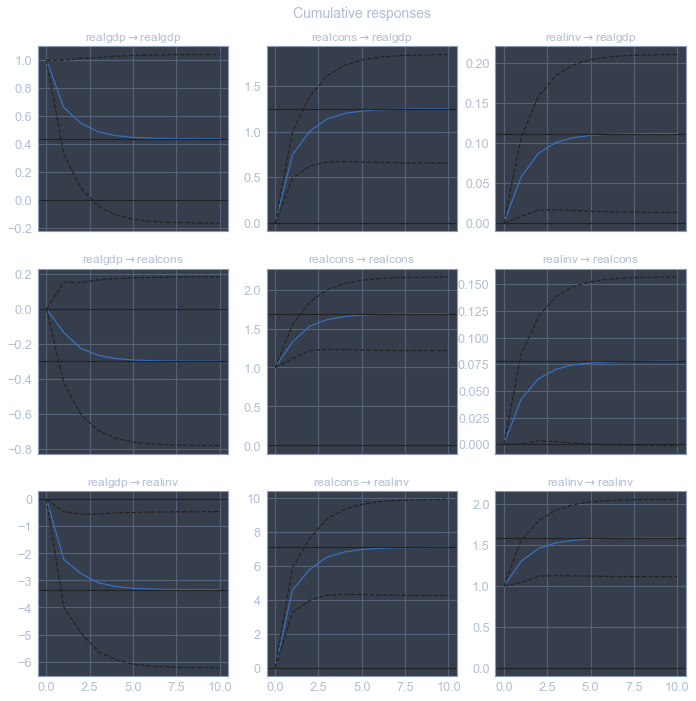

In [12]:
# Cumulated IRF

irf.plot_cum_effects(orth=False);

## Forecast Error Variance Decomposition (FEVD)

In [13]:
fevd = results.fevd(5)

fevd.summary()

FEVD for realgdp
      realgdp  realcons   realinv
0    1.000000  0.000000  0.000000
1    0.863290  0.117446  0.019264
2    0.852569  0.123851  0.023579
3    0.849514  0.126098  0.024387
4    0.848953  0.126485  0.024563

FEVD for realcons
      realgdp  realcons   realinv
0    0.369003  0.630997  0.000000
1    0.387804  0.595911  0.016285
2    0.387739  0.593203  0.019058
3    0.388036  0.592295  0.019669
4    0.388073  0.592133  0.019794

FEVD for realinv
      realgdp  realcons   realinv
0    0.576515  0.160707  0.262779
1    0.489217  0.292549  0.218234
2    0.490804  0.291795  0.217401
3    0.490118  0.293047  0.216835
4    0.490068  0.293178  0.216754




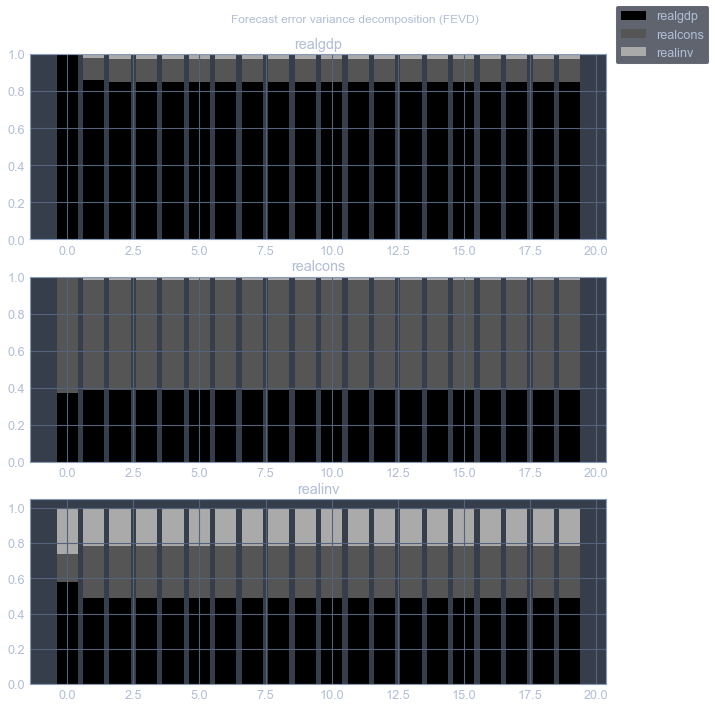

In [14]:
#Plot FEVD

results.fevd(20).plot();

# Simulated part

In [15]:
data_sim = data.copy()

for i in range(0,len(data_sim.columns)):
    data_sim.iloc[:,i] = random()

In [16]:
model_sim = VAR(data)
results_sim = model_sim.fit(2)
results_sim.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Dec, 2018
Time:                     20:43:09
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

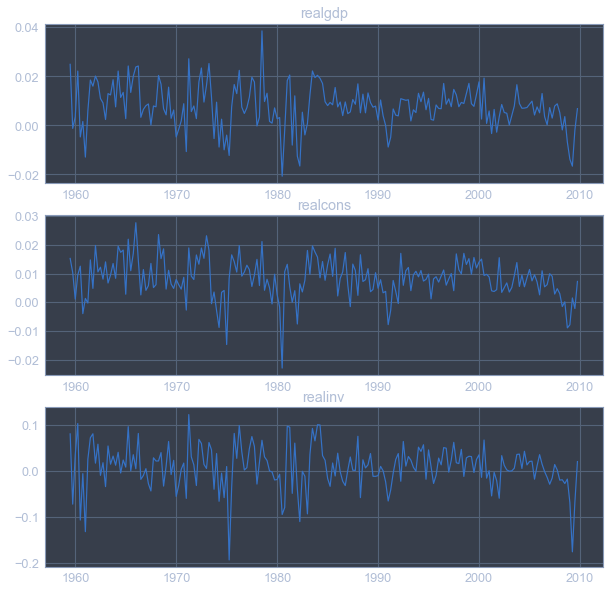

In [17]:
results_sim.plot();